In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd drive/MyDrive/DeepFake_Detection
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Imports

In [2]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, ReLU, ELU, LeakyReLU, Dropout, Dense, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from math import floor, log
from datetime import datetime
import os

In [2]:

%load_ext tensorboard

In [3]:
IMG_WIDTH = 1024

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

# Data

In [4]:
def get_datagen(use_default_augmentation=True, **kwargs):
    kwargs.update({'rescale': 1./255})
    if use_default_augmentation:
        kwargs.update({
            'rotation_range': 15,
            'zoom_range': 0.2,
            'brightness_range': (0.8, 1.2),
            'channel_shift_range': 30,
            'horizontal_flip': True,
        })
    return ImageDataGenerator(**kwargs)

In [5]:
def get_train_data_generator(
    train_data_dir, 
    batch_size, 
    validation_split=None, 
    use_default_augmentation=True,
    augmentations=None
):
    if not augmentations:
        augmentations = {}

    train_datagen = get_datagen(
        use_default_augmentation=use_default_augmentation,
        validation_split=validation_split if validation_split else 0.0,
        **augmentations
    )
   
    train_generator = train_datagen.flow_from_directory(
        directory=train_data_dir,
        target_size=(IMG_WIDTH, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
    )

    validation_generator = None

    if validation_split:
        validation_generator = train_datagen.flow_from_directory(
            directory=train_data_dir,
            target_size=(IMG_WIDTH, IMG_WIDTH),
            batch_size=batch_size,
            class_mode='binary',
            subset='validation'
        )

    return train_generator, validation_generator

In [6]:
def get_test_data_generator(test_data_dir, batch_size, shuffle=False):
    test_datagen = get_datagen(use_default_augmentation=False)
    return test_datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(IMG_WIDTH, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=shuffle
    )

# Model

In [7]:
def activation_layer(ip, activation, *args):
    return {'relu': ReLU(*args)(ip),
            'elu': ELU(*args)(ip),
            'lrelu': LeakyReLU(*args)(ip)}[activation]

In [8]:
def conv2D(ip,
           filters,
           kernel_size,
           activation,
           padding='same',
           pool_size=(2, 2)):
    layer = Conv2D(filters,
                   kernel_size=kernel_size,
                   padding=padding)(ip)

    layer = activation_layer(layer, activation=activation)

    layer = BatchNormalization()(layer)

    return MaxPooling2D(pool_size=pool_size, padding=padding)(layer)

In [9]:
def fully_connected_layer(ip,
                          hidden_activation,
                          dropout):
    layer = Dense(16)(ip)
    layer = activation_layer(layer, hidden_activation, *[0.1,])
    return Dropout(rate=dropout)(layer)

In [10]:
def build_model(ip=Input(shape=(IMG_WIDTH, IMG_WIDTH, 3)),
                activation='relu',
                dropout=0.5,
                hidden_activation='lrelu'):
    
    layer = conv2D(ip, filters=8, kernel_size=(3, 3), activation=activation)

    layer = conv2D(layer, filters=8, kernel_size=(5, 5), activation=activation)

    layer = conv2D(layer, filters=16, kernel_size=(5, 5), activation=activation)

    layer = conv2D(layer, filters=16, kernel_size=(5, 5), activation=activation, pool_size=(4, 4))

    layer = Flatten()(layer)
    layer = Dropout(rate=dropout)(layer)

    layer = fully_connected_layer(layer, hidden_activation=hidden_activation, dropout=dropout)

    op_layer = Dense(1, activation='sigmoid')(layer)

    model = Model(ip, op_layer)

    return model

In [11]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_model(model, test_data_dir, batch_size):
    data = get_test_data_generator(test_data_dir, batch_size)
    return model.evaluate(data)


def predict(model, data, steps=None, threshold=0.5, nameModel="", fake=False, real=False):
    predictions = model.predict(data, steps=steps, verbose=1)
    
    if fake == False and real == False:
        index_real_one = np.where(data.classes == 1)[0][0]
        predict_fake_images = predictions[:index_real_one]
        predict_real_images = predictions[index_real_one:]
        data_to_save_fake = np.column_stack((data.filenames[:index_real_one], predict_fake_images))
        data_to_save_real = np.column_stack((data.filenames[index_real_one:], predict_real_images))
        np.savetxt(f'predict_fake_images_new_{nameModel}.txt', data_to_save_fake, fmt='%s')
        np.savetxt(f'predict_real_images_new_{nameModel}.txt', data_to_save_real, fmt='%s')
        
        # Данные для ROC кривой
        true_labels = np.concatenate((np.zeros(len(predict_fake_images)), np.ones(len(predict_real_images))))
        predicted_probabilities = np.concatenate((predict_fake_images, predict_real_images))

        # Вычисление ROC кривой и площади под кривой (AUC)
        fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
        roc_auc = roc_auc_score(true_labels, predicted_probabilities)
        print(f'ROC_AUC: {roc_auc}')        
        # Построение ROC кривой
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    if fake == True:
        data_to_save_fake = np.column_stack((data.filenames, predictions))
        np.savetxt(f'predict_fake_images_{nameModel}.txt', data_to_save_fake, fmt='%s')

    if real == True:
        data_to_save_real = np.column_stack((data.filenames, predictions))
        np.savetxt(f'predict_real_images_{nameModel}.txt', data_to_save_real, fmt='%s')

    return predictions, np.where(predictions >= threshold, 1, 0)


def save_model_history(history, filename):
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)

In [12]:
def get_activation_model(model, conv_idx):
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    selected_layers = [layer for index, layer in enumerate(conv_layers) if index in conv_idx]
    activation_model = Model(
        inputs=model.inputs,
        outputs=[layer.output for layer in selected_layers]
    )
    return activation_model

# Visualization

In [13]:
def plot_loss_curve(history):
    plt.plot(history.history['loss'], 'r', label='train')
    plt.plot(history.history['val_loss'], 'g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [14]:
def get_classification_report(
    model, data_dir, batch_size=64,
    steps=None, threshold=0.5, output_dict=False, nameModel="", fake=False, real=False
):
    data = get_test_data_generator(data_dir, batch_size=batch_size)
    predictions = predict(model, data, steps, threshold, nameModel, fake, real)
    predictions = predictions[1].reshape((predictions[0].shape[0],))
    return classification_report(data.classes, predictions, output_dict=output_dict)

In [15]:
def visualize_conv_layers_single_img(
    activations,
    conv_idx,
):
    images_per_row = 4

    for activation, idx in zip(activations, conv_idx):
        num_filters = activation.shape[-1]

        imgs = [activation[:, :, i] for i in range(num_filters)]

        num_rows = num_filters // images_per_row

        fig = plt.figure()
        grid = ImageGrid(fig, 111, (num_rows, images_per_row))

        for ax, im in zip(grid, imgs):
            ax.imshow(im, cmap='viridis')

        plt.title(f'Convolutional Layer {idx + 1}')
        plt.show()


def visualize_conv_layers(model, imgs, conv_idx):
    activation_model = get_activation_model(model, conv_idx)
    activations = activation_model.predict(imgs)

    num_imgs = imgs.shape[0]
    num_layers = len(conv_idx)

    for idx in range(num_imgs):
        img_activs = [activations[i][idx, :, :, :] for i in range(num_layers)]
        visualize_conv_layers_single_img(
            activations=img_activs, conv_idx=conv_idx
        )

# Training

In [17]:
def train_model(model,
                train_data_dir,
                validation_split=None,
                batch_size=32,
                use_default_augmentation=True,
                augmentations=None,
                epochs=30,
                lr=1e-3,
                loss='binary_crossentropy',
                compile=True,
                lr_decay=True,
                decay_rate=0.10,
                decay_limit=1e-6,
                checkpoint=True,
                stop_early=True,
                monitor='val_accuracy',
                mode='max',
                patience=20,
                tensorboard=True,
                loss_curve=True):
    
    run_time = datetime.now().strftime("%Y%m%d-%H%M%S")

    train_generator, validation_generator = get_train_data_generator(
        train_data_dir=train_data_dir,
        batch_size=batch_size,
        validation_split=validation_split,
        use_default_augmentation=use_default_augmentation,
        augmentations=augmentations
    )

    callbacks = []
    if checkpoint:
        filepath = f'run_{run_time}_best_model_E4E_Older.hdf5'
        model_checkpoint = ModelCheckpoint(
            filepath, monitor='val_accuracy', verbose=1,
            save_best_only=True
        )
        callbacks.append(model_checkpoint)

    if stop_early:
        callbacks.append(
            EarlyStopping(
                monitor=monitor,
                mode=mode,
                patience=patience,
                verbose=1
            )
        )

    if tensorboard:
        log_dir = "logs/fit/" + run_time
        callbacks.append(TensorBoard(log_dir, histogram_freq=1, write_images=True))

    if compile:
        if lr_decay:
            num_times = floor(log(decay_limit / lr, decay_rate))
            per_epoch = epochs // num_times
            lr = ExponentialDecay(
                lr,
                decay_steps=(train_generator.samples // batch_size) * per_epoch,
                decay_rate=decay_rate,
                staircase=True,
            )
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size if validation_generator else None,
    )

    if loss_curve:
        plot_loss_curve(history)

    return history

# Driver (Main)

In [16]:
import scipy

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 1.2124 - accuracy: 0.6812
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to run_20240311-230818_best_model_E4E_Older.hdf5
40/40 [==============================] - 34s 774ms/step - loss: 1.2124 - accuracy: 0.6812 - val_loss: 1.1842 - val_accuracy: 0.5000
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.8687
Epoch 2: val_accuracy did not improve from 0.50000
40/40 [==============================] - 30s 744ms/step - loss: 0.5617 - accuracy: 0.8687 - val_loss: 1.3099 - val_accuracy: 0.5000
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.4183 - accuracy: 0.9187
Epoch 3: val_accuracy improved from 0.50000 to 0.67500, saving model to run_20240311-230818_best_model_E4E_Older.hdf5
40/40 [==============================] - 29s 734ms/step - loss: 0.4183 - accuracy: 0.9187

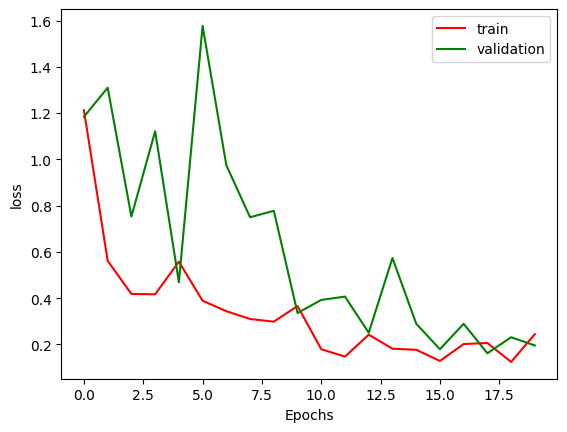

In [19]:
def main(train_data_dir):
    val_split, epochs, batch_size = 0.20, 20, 4
    decay_rate, decay_limit = 0.10, 1e-6
    model = build_model()
    return model, train_model(
        model,
        train_data_dir,
        validation_split=val_split,
        epochs=epochs,
        stop_early=False,
        batch_size = batch_size,
        decay_rate=decay_rate,
        decay_limit=decay_limit,
    )


#model, history = main('D:/DeepFakeRepos/Datasets/RoopData/')
model, history = main('C:\\DatasetD\\E4EOlder_100')
model.save('model_E4E_Older_100_ep20.hdf5')

# Model Evaluation

## 11th Model

In [17]:
# Если модель базовая, то 128
IMG_WIDTH = 1024

baseModelPath = "D:\\DeepFakeRepos\\TestTrainModels\\MESO_BASE_model1_18epochs_valacc0.9252.hdf5"
roopModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Meso100\\model_MESO_ROOP_100_ep20.hdf5'
ghostModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Meso100\\model_MESO_GHOST_100_ep20.hdf5'
olderModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Meso100\\model_MESO_E4E_Older_100_ep20.hdf5'
smileModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Meso100\\model_MESO_E4E_Smile_100_ep20.hdf5'

# Все выборки по 100
roopDataPath = "D:\\DeepFakeRepos\\Datasets\\RoopData"
ghostDataPath = "D:\\DeepFakeRepos\\Datasets\\GhostData"
olderDataPath = "D:\\DeepFakeRepos\\Datasets\\OlderData"
smileDataPath = "D:\\DeepFakeRepos\\Datasets\\SmileData"
faceForensicsPath = "D:\\DeepFakeRepos\\Datasets\\FaceForensics"

baseDataTestPath = "D:\\DeepFakeRepos\\AllModels\\DeepFakeDetectionModels\\MesoNet-DeepFakeDetection\\data\\test"


BASE_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 2s 71ms/step
ROC_AUC: 0.9946454353191545


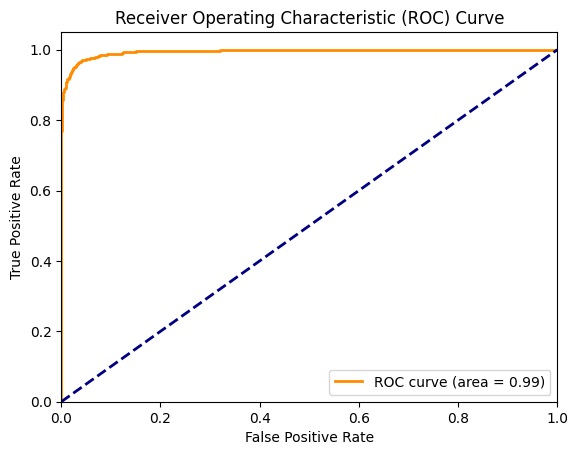

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       773
           1       0.97      0.97      0.97      1172

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 5s 1s/step
ROC_AUC: 0.5645


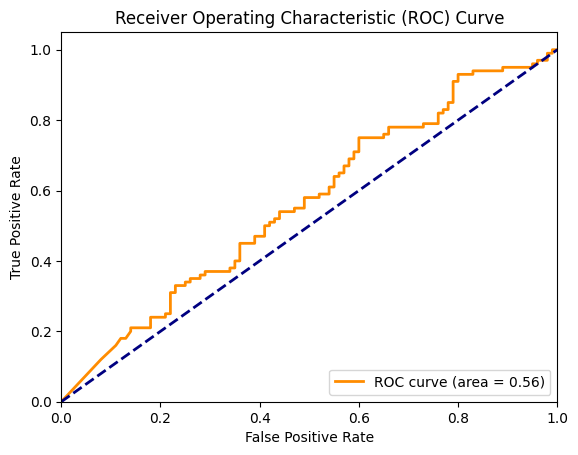

              precision    recall  f1-score   support

           0       0.40      0.02      0.04       100
           1       0.50      0.97      0.66       100

    accuracy                           0.49       200
   macro avg       0.45      0.49      0.35       200
weighted avg       0.45      0.49      0.35       200

GhostData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 5s 1s/step
ROC_AUC: 0.5138


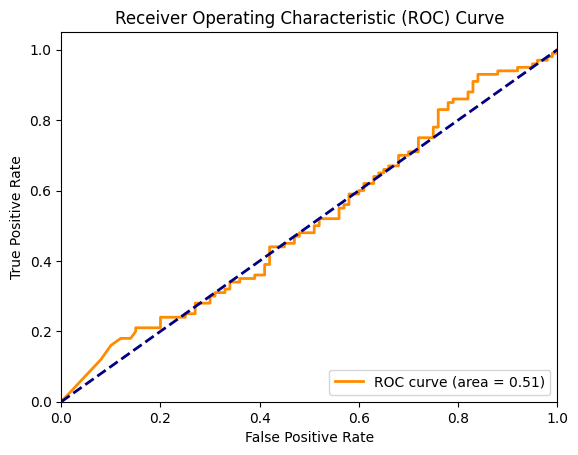

              precision    recall  f1-score   support

           0       0.40      0.02      0.04       100
           1       0.50      0.97      0.66       100

    accuracy                           0.49       200
   macro avg       0.45      0.49      0.35       200
weighted avg       0.45      0.49      0.35       200

E4E_OlderData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 5s 1s/step
ROC_AUC: 0.52835


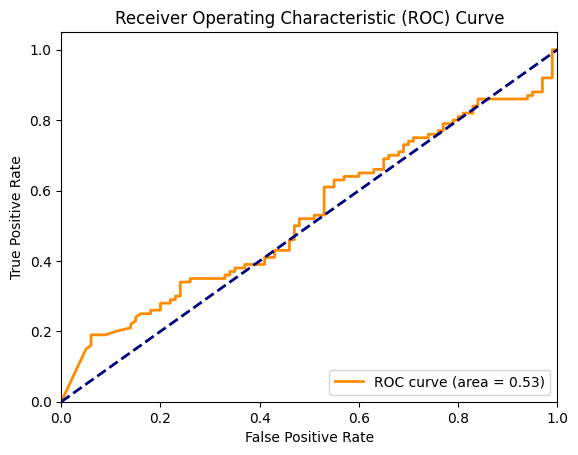

              precision    recall  f1-score   support

           0       0.33      0.01      0.02       100
           1       0.50      0.98      0.66       100

    accuracy                           0.49       200
   macro avg       0.42      0.49      0.34       200
weighted avg       0.42      0.49      0.34       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 5s 1s/step
ROC_AUC: 0.38605


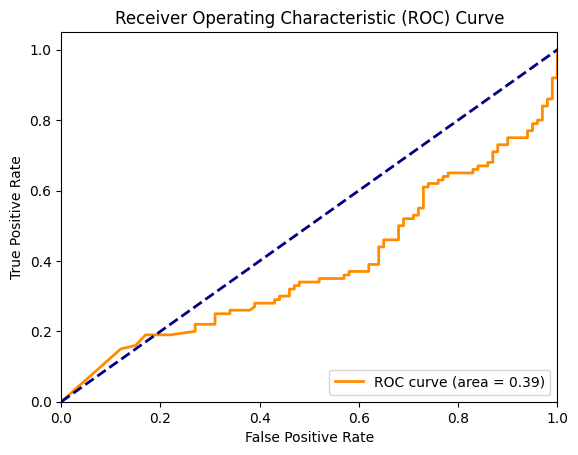

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.49      0.98      0.66       100

    accuracy                           0.49       200
   macro avg       0.25      0.49      0.33       200
weighted avg       0.25      0.49      0.33       200



In [28]:
IMG_WIDTH = 256
model_exp = load_model(baseModelPath)

print("BASE_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="BaseData"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="BaseData"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="BaseData"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="BaseData"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="BaseData"))

#0 - фейк
#1 - реальные

ROOP_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 74s 2s/step
ROC_AUC: 0.49548101673811973


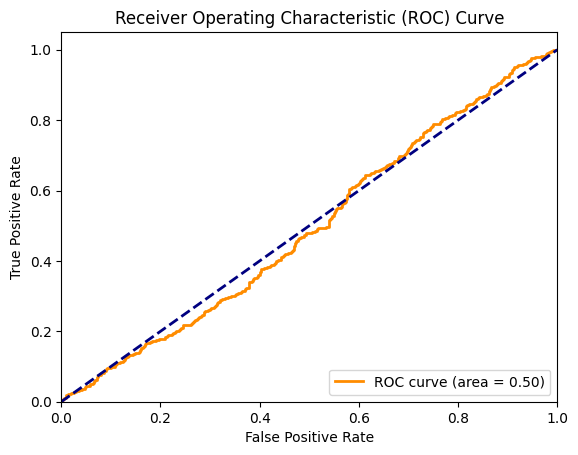

              precision    recall  f1-score   support

           0       0.40      1.00      0.57       773
           1       0.00      0.00      0.00      1172

    accuracy                           0.40      1945
   macro avg       0.20      0.50      0.28      1945
weighted avg       0.16      0.40      0.23      1945

RoopData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 10s 2s/step
ROC_AUC: 0.5559999999999999


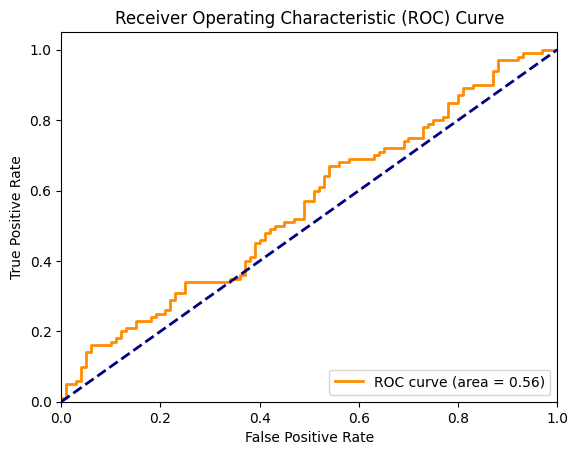

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

GhostData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 10s 2s/step
ROC_AUC: 0.5961


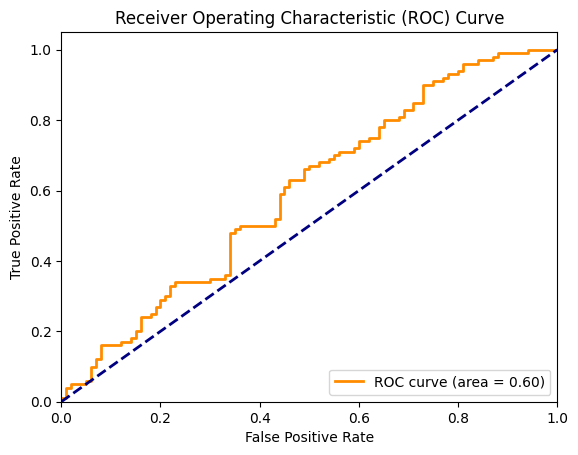

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

E4E_OlderData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 10s 2s/step
ROC_AUC: 0.523


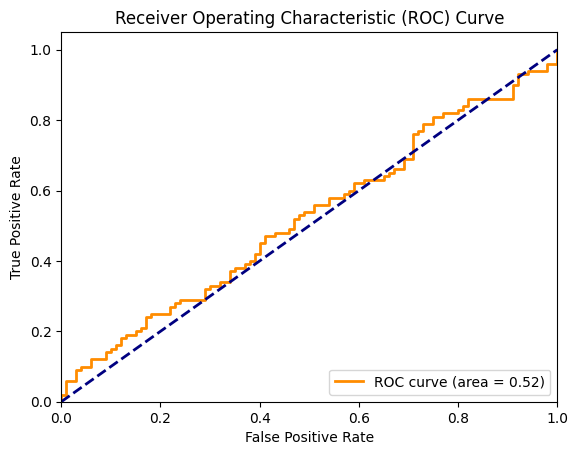

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

E4E_SmileData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 10s 2s/step
ROC_AUC: 0.42530000000000007


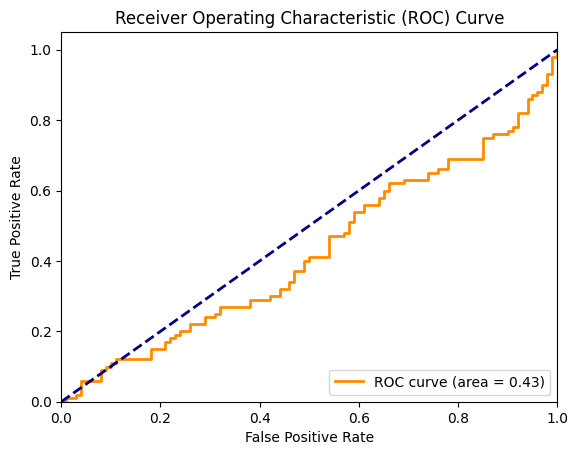

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
IMG_WIDTH = 1024
model_exp = load_model(roopModelPath)

print("ROOP_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="ROOP"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="ROOP"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="ROOP"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="ROOP"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="ROOP"))

#0 - фейк
#1 - реальные

In [18]:
print(get_classification_report(model_exp, 'F:\\DeepFakeRepos\\Datasets\\FaceForensics', nameModel="FaceForensics", fake=True))
# Faceforensics


Found 200 images belonging to 2 classes.


4/4 [==============================] - 2s 423ms/step
              precision    recall  f1-score   support

           0       0.57      0.04      0.07       100
           1       0.50      0.97      0.66       100

    accuracy                           0.51       200
   macro avg       0.54      0.51      0.37       200
weighted avg       0.54      0.51      0.37       200



GHOST_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 112s 4s/step
ROC_AUC: 0.5619279523508868


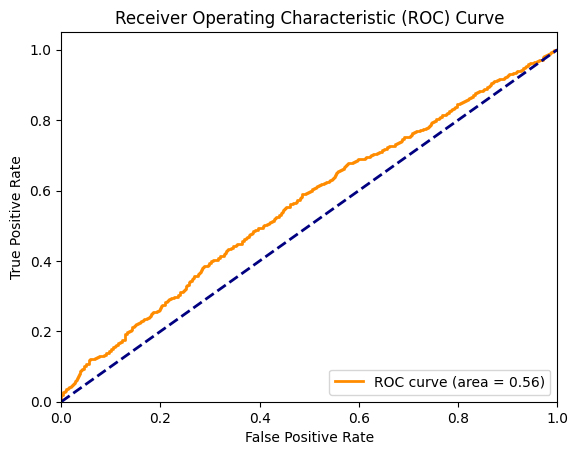

              precision    recall  f1-score   support

           0       0.43      0.69      0.53       773
           1       0.66      0.40      0.50      1172

    accuracy                           0.52      1945
   macro avg       0.55      0.55      0.52      1945
weighted avg       0.57      0.52      0.51      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 19s 4s/step
ROC_AUC: 0.5584


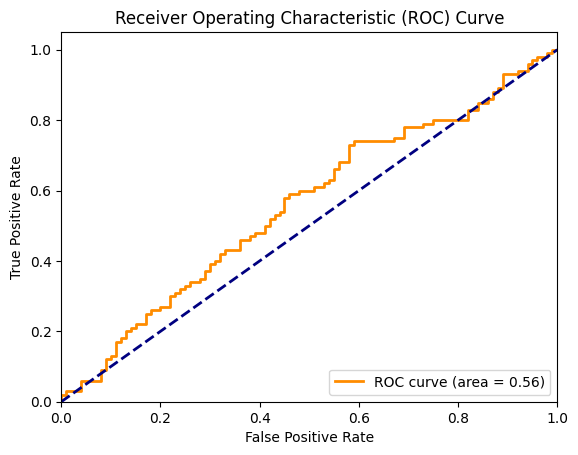

              precision    recall  f1-score   support

           0       0.54      0.59      0.56       100
           1       0.54      0.49      0.52       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200

GhostData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.497


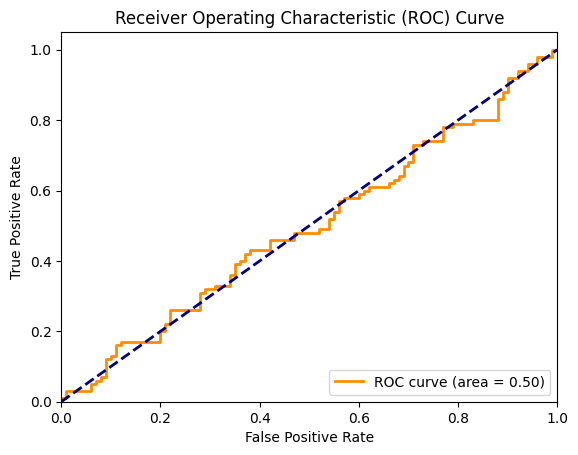

              precision    recall  f1-score   support

           0       0.48      0.47      0.47       100
           1       0.48      0.49      0.49       100

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200

E4E_OlderData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.43200000000000005


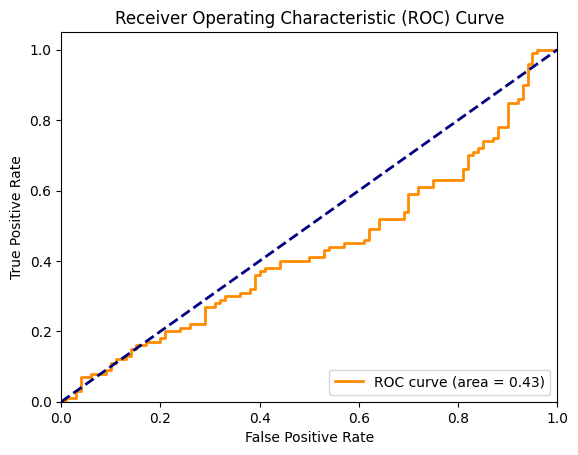

              precision    recall  f1-score   support

           0       0.43      0.42      0.43       100
           1       0.44      0.45      0.44       100

    accuracy                           0.43       200
   macro avg       0.43      0.43      0.43       200
weighted avg       0.43      0.43      0.43       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.44179999999999997


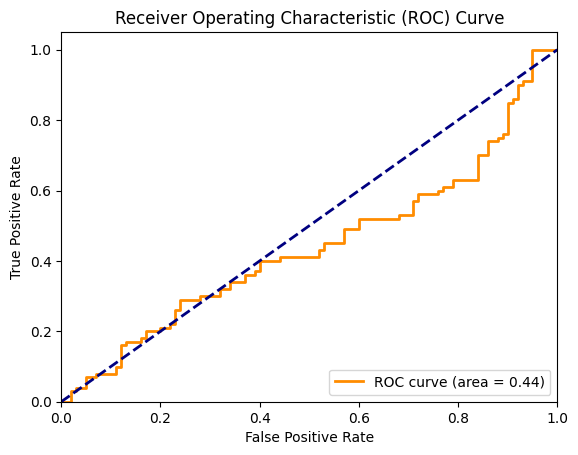

              precision    recall  f1-score   support

           0       0.44      0.44      0.44       100
           1       0.45      0.45      0.45       100

    accuracy                           0.45       200
   macro avg       0.44      0.45      0.44       200
weighted avg       0.44      0.45      0.44       200



In [19]:
IMG_WIDTH = 1024

ghost_500_model_path = "D:\\DeepFakeRepos\\TestTrainModels\\Meso500\\model_MESO_GHOST_500_ep20.hdf5"

model_exp = load_model(ghost_500_model_path)

print("GHOST_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="ROOP"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="GHOST"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="GHOST"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="GHOST"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="GHOST"))

#0 - фейк
#1 - реальные

# GHOST

Older_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 123s 4s/step
ROC_AUC: 0.6902934579604307


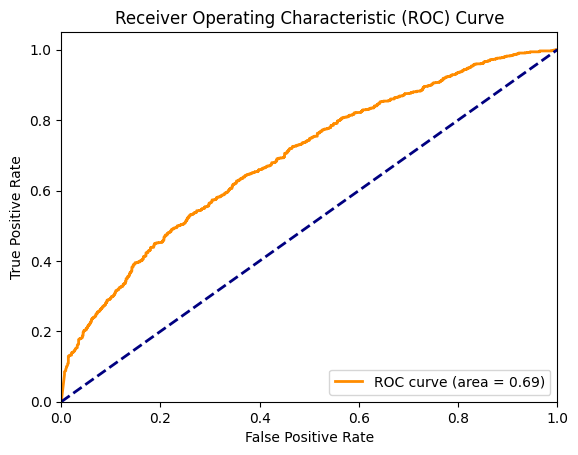

              precision    recall  f1-score   support

           0       0.60      0.40      0.48       773
           1       0.68      0.82      0.74      1172

    accuracy                           0.65      1945
   macro avg       0.64      0.61      0.61      1945
weighted avg       0.64      0.65      0.64      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 21s 5s/step
ROC_AUC: 0.44215


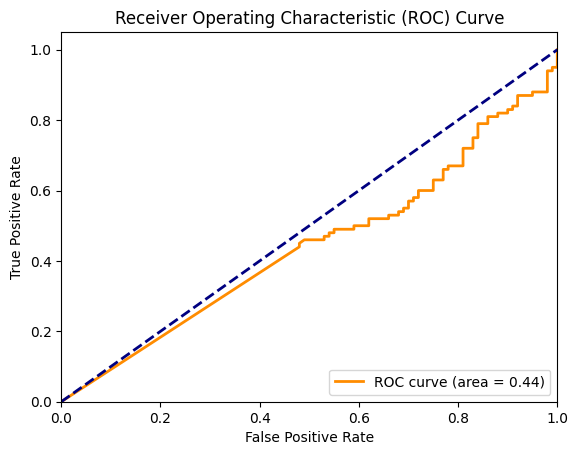

              precision    recall  f1-score   support

           0       0.35      0.07      0.12       100
           1       0.48      0.87      0.62       100

    accuracy                           0.47       200
   macro avg       0.42      0.47      0.37       200
weighted avg       0.42      0.47      0.37       200

GhostData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.46875


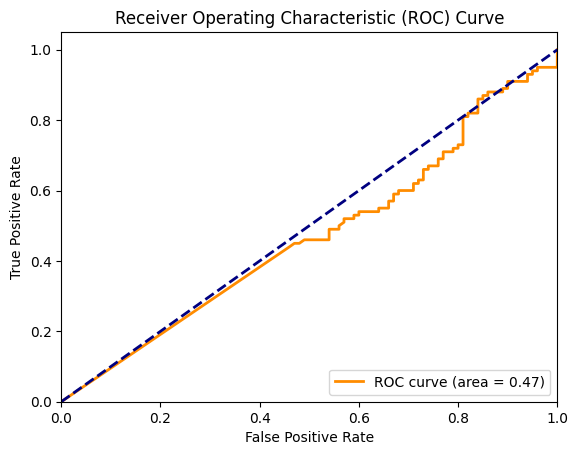

              precision    recall  f1-score   support

           0       0.52      0.14      0.22       100
           1       0.50      0.87      0.64       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.43       200
weighted avg       0.51      0.51      0.43       200

E4E_OlderData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.9786


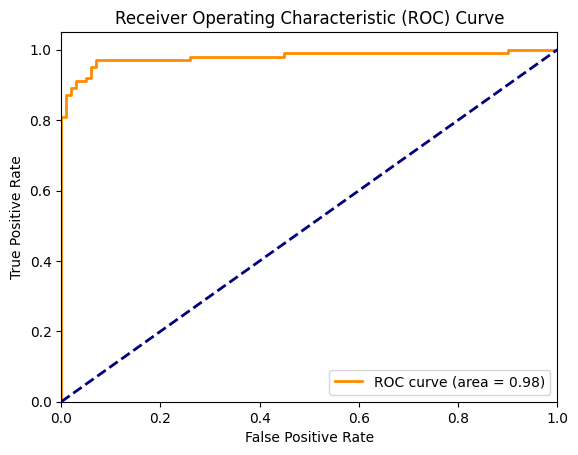

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       100
           1       0.98      0.87      0.92       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 21s 4s/step
ROC_AUC: 0.8875


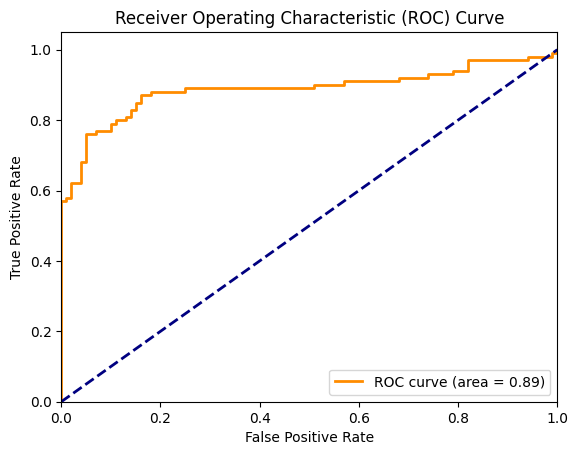

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       100
           1       0.84      0.87      0.85       100

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



In [20]:
IMG_WIDTH = 1024

model_exp = load_model(olderModelPath)

print("Older_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="Older"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="Older"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="Older"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="Older"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="Older"))
# OldAgeAttribute

Smile_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 124s 4s/step
ROC_AUC: 0.7075106296553033


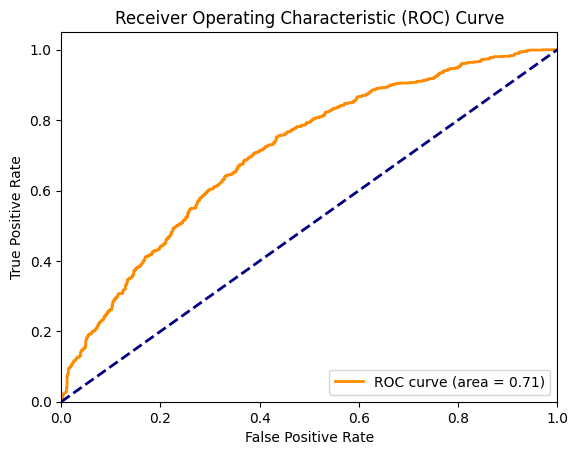

              precision    recall  f1-score   support

           0       0.53      0.72      0.61       773
           1       0.76      0.57      0.65      1172

    accuracy                           0.63      1945
   macro avg       0.64      0.65      0.63      1945
weighted avg       0.67      0.63      0.64      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.46765


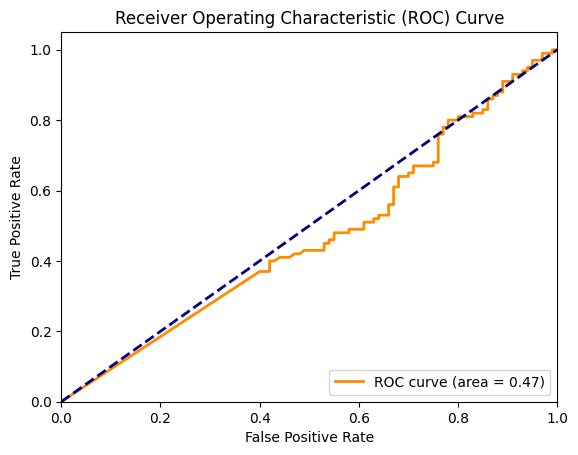

              precision    recall  f1-score   support

           0       0.56      0.09      0.16       100
           1       0.51      0.93      0.65       100

    accuracy                           0.51       200
   macro avg       0.53      0.51      0.41       200
weighted avg       0.53      0.51      0.41       200

GhostData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.49405000000000004


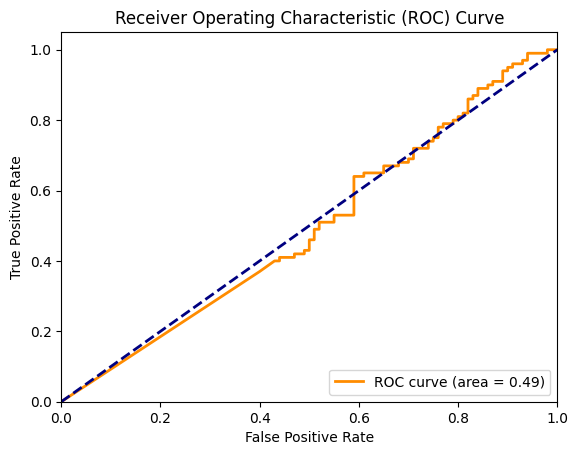

              precision    recall  f1-score   support

           0       0.61      0.11      0.19       100
           1       0.51      0.93      0.66       100

    accuracy                           0.52       200
   macro avg       0.56      0.52      0.42       200
weighted avg       0.56      0.52      0.42       200

E4E_OlderData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.9935


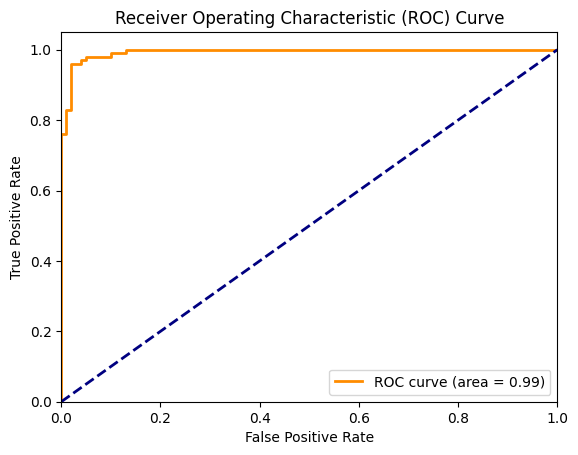

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       100
           1       0.96      0.97      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.9974


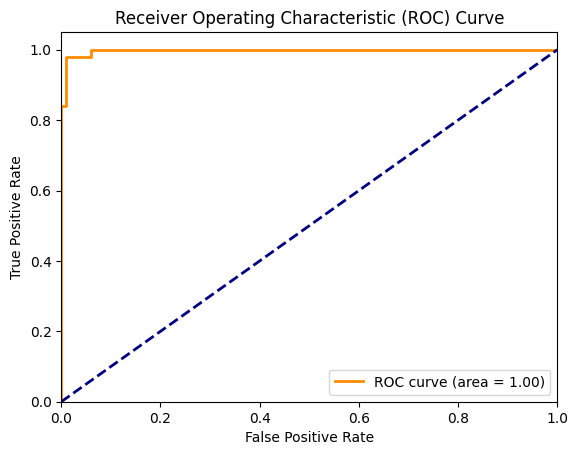

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       0.99      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [21]:
IMG_WIDTH = 1024

model_exp = load_model(smileModelPath)

print("Smile_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="Smile"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="Smile"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="Smile"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="Smile"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="Smile"))
# Smile

GHOST_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 77s 2s/step
ROC_AUC: 0.5594510108658699


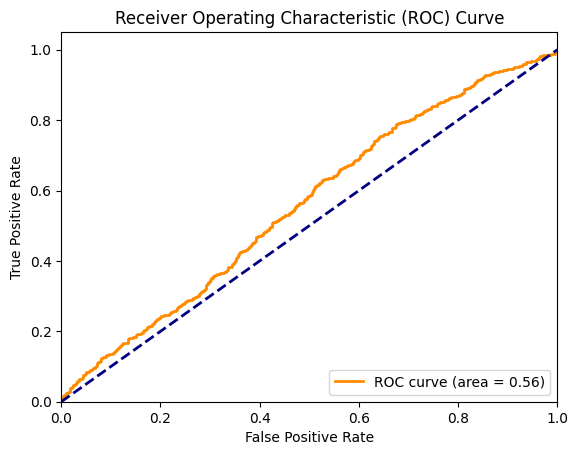

              precision    recall  f1-score   support

           0       0.40      1.00      0.57       773
           1       0.00      0.00      0.00      1172

    accuracy                           0.40      1945
   macro avg       0.20      0.50      0.28      1945
weighted avg       0.16      0.40      0.23      1945

RoopData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.449


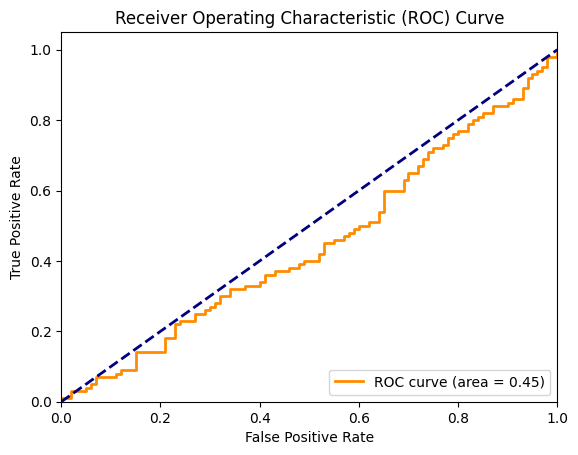

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

GhostData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.5755


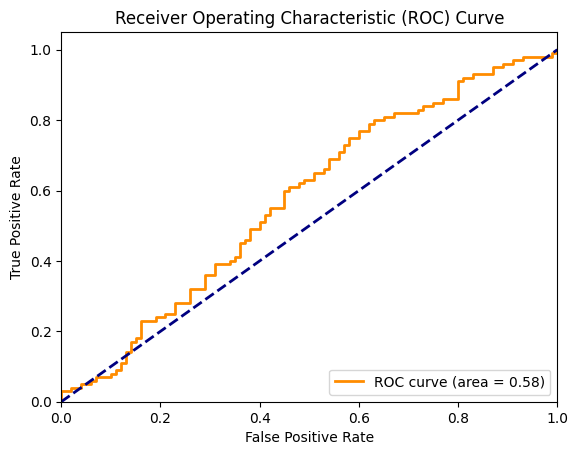

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

E4E_OlderData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.5369999999999999


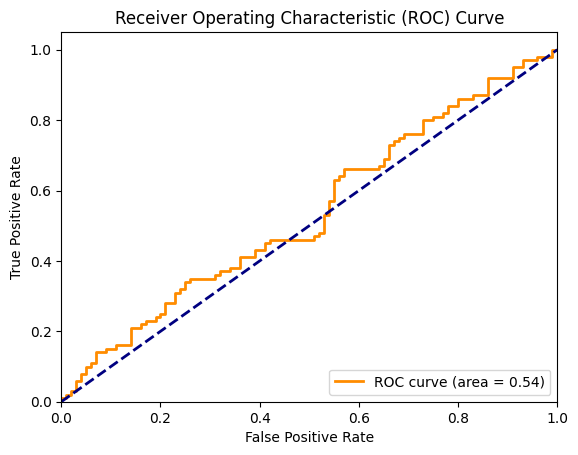

c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 20s 4s/step
ROC_AUC: 0.5053


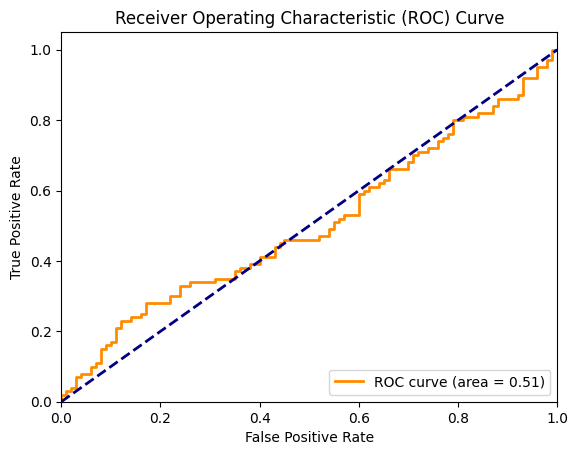

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
IMG_WIDTH = 1024

model_exp = load_model(ghostModelPath)

print("GHOST_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="GHOST"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="GHOST"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="GHOST"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="GHOST"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="GHOST"))

# GHOST100

BaseData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 2s 362ms/step
ROC_AUC: 0.7957000000000001


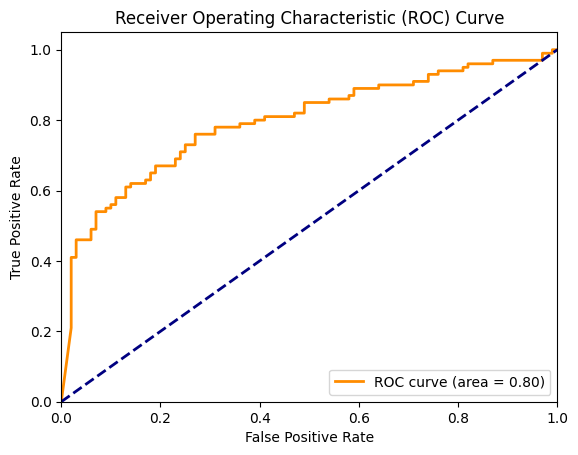

              precision    recall  f1-score   support

           0       0.57      0.04      0.07       100
           1       0.50      0.97      0.66       100

    accuracy                           0.51       200
   macro avg       0.54      0.51      0.37       200
weighted avg       0.54      0.51      0.37       200

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 9s 2s/step
ROC_AUC: 0.5969000000000001


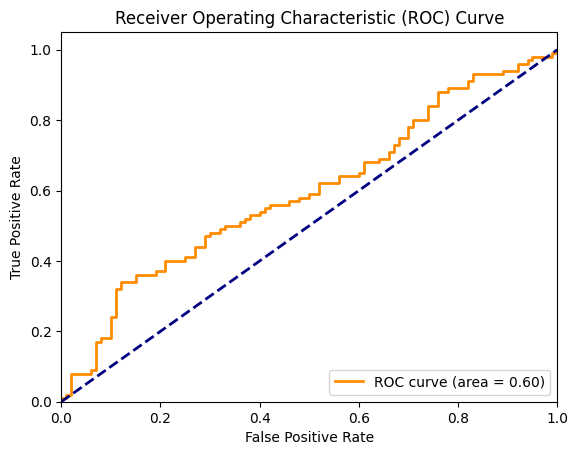

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

GhostData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 9s 2s/step
ROC_AUC: 0.32020000000000004


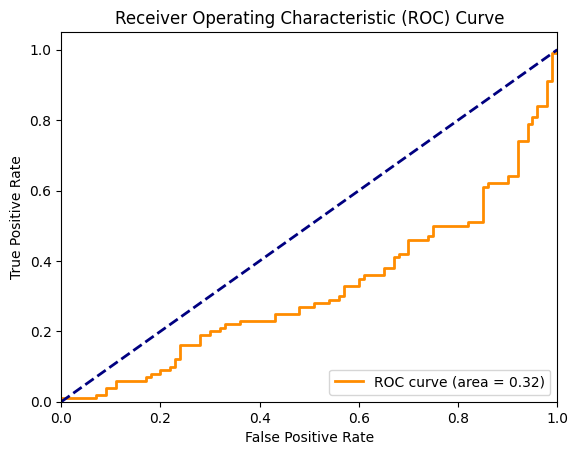

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

E4E_OlderData
Found 200 images belonging to 2 classes.


c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Apps\envs\MesoNet\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 9s 2s/step
ROC_AUC: 0.29515


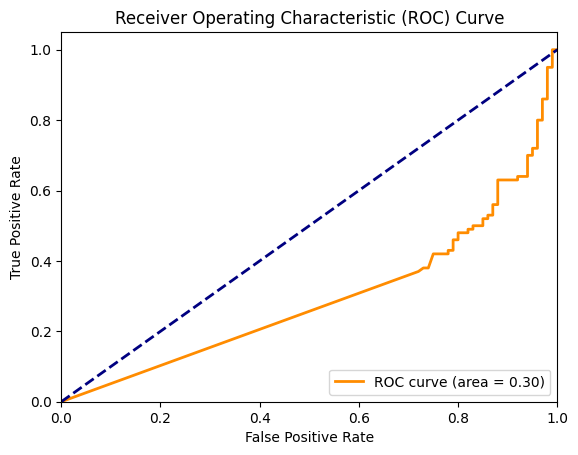

              precision    recall  f1-score   support

           0       0.13      0.04      0.06       100
           1       0.43      0.73      0.54       100

    accuracy                           0.38       200
   macro avg       0.28      0.39      0.30       200
weighted avg       0.28      0.39      0.30       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 9s 2s/step
ROC_AUC: 0.21630000000000002


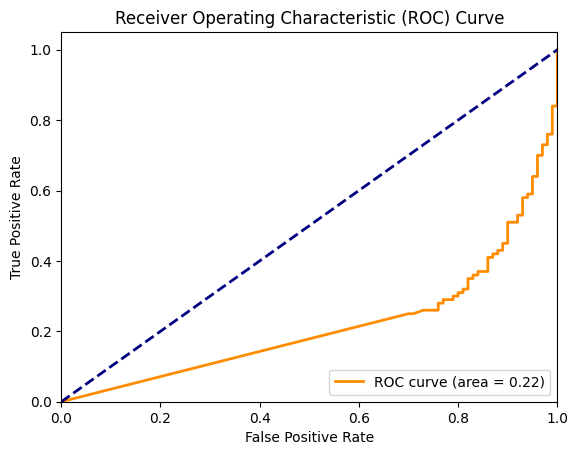

              precision    recall  f1-score   support

           0       0.04      0.01      0.02       100
           1       0.44      0.78      0.56       100

    accuracy                           0.40       200
   macro avg       0.24      0.40      0.29       200
weighted avg       0.24      0.40      0.29       200



In [23]:
IMG_WIDTH = 256
model_exp = load_model(baseModelPath)
print("BaseData")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="Base"))

IMG_WIDTH = 1024
model_exp = load_model(roopModelPath)
print("RoopData")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="Roop"))

model_exp = load_model(ghostModelPath)
print("GhostData")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="Ghost"))

model_exp = load_model(olderModelPath)
print("E4E_OlderData")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="Older"))

model_exp = load_model(smileModelPath)
print("E4E_SmileData")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="Smile"))
# FF AllModels

Found 200 images belonging to 2 classes.
4/4 [==============================] - 16s 3s/step
ROC_AUC: 0.4932


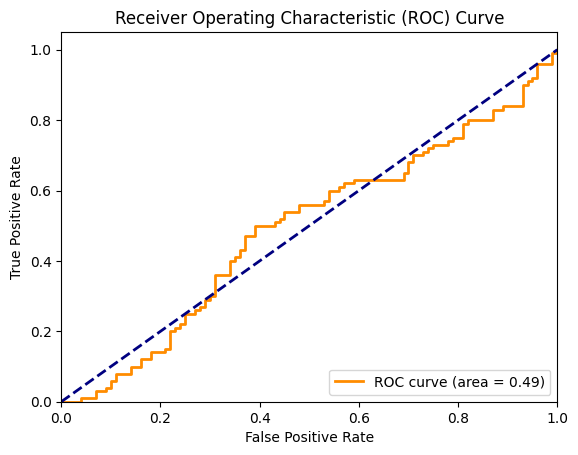

              precision    recall  f1-score   support

           0       0.54      0.57      0.55       100
           1       0.54      0.51      0.53       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200



In [24]:
model_exp = load_model(ghost_500_model_path)
print(get_classification_report(model_exp, faceForensicsPath, nameModel="ghost500"))
# FF AllModels

# Testing Hidden Layer Visualization

Found 1945 images belonging to 2 classes.
1/1 [==============================] - 0s 350ms/step


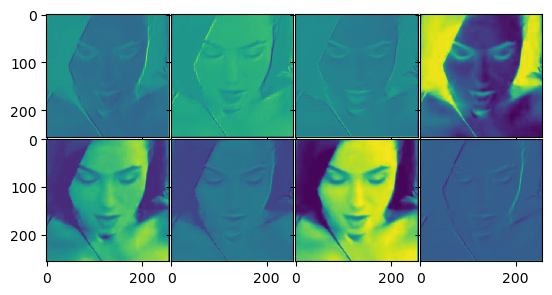

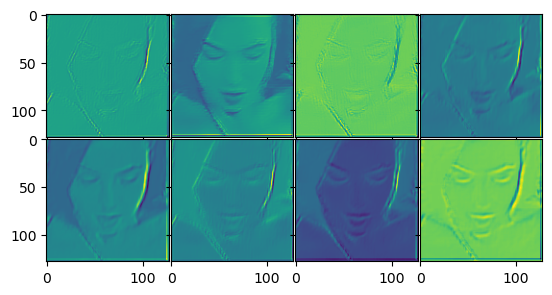

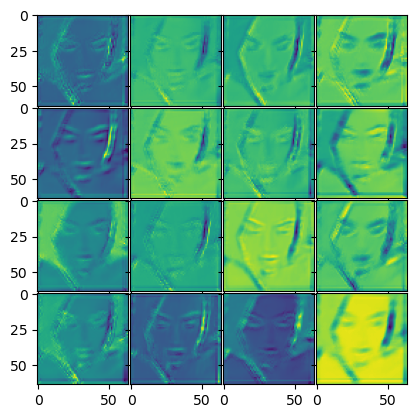

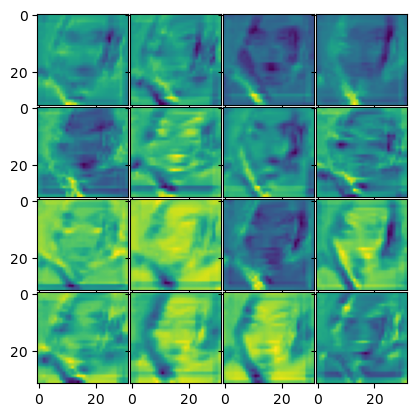

In [32]:
model_exp = load_model('F:\\DeepFakeDetectionModels\\MesoNet-DeepFakeDetection\\trained_models\\model1_18epochs_valacc0.9252.hdf5')
number_of_images = 1
data = get_test_data_generator('F:\\DeepFakeDetectionModels\\MesoNet-DeepFakeDetection\\data\\test', number_of_images, shuffle=True)
batch_idx = np.random.randint(0, data.samples // data.batch_size)
imgs, labels = data[batch_idx]
visualize_conv_layers(model_exp, imgs, [0, 1, 2, 3])